,guest,hotel,final_price,guest_satisfaction
0,guest_982,hotel_82,€256.41,5
1,guest_286,hotel_78,€120.69,3
2,guest_1769,hotel_3,€117.03,4
3,guest_13,hotel_306,€200.97,5
4,guest_2315,hotel_115,€202.52,5


,Metric,Value
0,Total Guests Allocated,"3,933"
1,Total Rooms Filled,"3,933"
2,Number of Hotels Utilized,394
3,Full Capacity Hotels Count,316
4,Overall Revenue Earned,"€625,179.7100"
5,Average Earnings Per Hotel,"€1,586.7500"
6,Average Guest Satisfaction,3.45


C:\Users\irpay\results\random_allocation_results.csv

C:\Users\irpay\results\summary_report_random_allocation.txt

,guest,hotel,final_price,guest_satisfaction
0,guest_1,hotel_168,€271.18,1
1,guest_2,hotel_369,€133.00,1
2,guest_3,hotel_157,€60.45,1
3,guest_4,hotel_235,€136.00,1
4,guest_5,hotel_121,€50.40,1


,Metric,Value
0,Total Guests Allocated,"3,975"
1,Total Rooms Filled,"3,975"
2,Number of Hotels Utilized,400
3,Full Capacity Hotels Count,255
4,Overall Revenue Earned,"€643,597.5300"
5,Average Earnings Per Hotel,"€1,608.9900"
6,Average Guest Satisfaction,1.32


C:\Users\irpay\results\customer_preference_results.csv

C:\Users\irpay\results\summary_report_customer_preference.txt

,guest,hotel,final_price,guest_satisfaction
0,guest_1,hotel_22,€55.51,5
1,guest_2,hotel_26,€55.00,4
2,guest_3,hotel_6,€53.94,2
3,guest_4,hotel_321,€54.00,5
4,guest_5,hotel_121,€50.40,1


,Metric,Value
0,Total Guests Allocated,"3,925"
1,Total Rooms Filled,"3,925"
2,Number of Hotels Utilized,388
3,Full Capacity Hotels Count,319
4,Overall Revenue Earned,"€564,085.0800"
5,Average Earnings Per Hotel,"€1,453.8300"
6,Average Guest Satisfaction,3.42


C:\Users\irpay\results\Price Allocation_results.csv

C:\Users\irpay\results\summary_report_Price Allocation.txt

,guest,hotel,final_price,guest_satisfaction
0,guest_1,hotel_269,€115.57,5
1,guest_2,hotel_79,€75.00,4
2,guest_3,hotel_179,€159.03,3
3,guest_4,hotel_212,€205.00,5
4,guest_5,hotel_85,€263.70,5


,Metric,Value
0,Total Guests Allocated,"3,874"
1,Total Rooms Filled,"3,874"
2,Number of Hotels Utilized,397
3,Full Capacity Hotels Count,344
4,Overall Revenue Earned,"€629,523.3500"
5,Average Earnings Per Hotel,"€1,585.7000"
6,Average Guest Satisfaction,3.46


C:\Users\irpay\results\availability_allocation_results.csv

C:\Users\irpay\results\summary_report_availability_allocation.txt

,Strategy,Total Guests Allocated,Total Rooms Filled,Number of Hotels Utilized,Full Capacity Hotels Count,Overall Revenue Earned,Average Earnings Per Hotel,Average Guest Satisfaction
0,Random Allocation,3933.0,3933.0,394.0,316.0,625179.71,1586.75,3.45
1,Customer Preference Allocation,3975.0,3975.0,400.0,255.0,643597.53,1608.99,1.32
2,Price Allocation,3925.0,3925.0,388.0,319.0,564085.08,1453.83,3.42
3,Availability Allocation,3874.0,3874.0,397.0,344.0,629523.35,1585.70,3.46


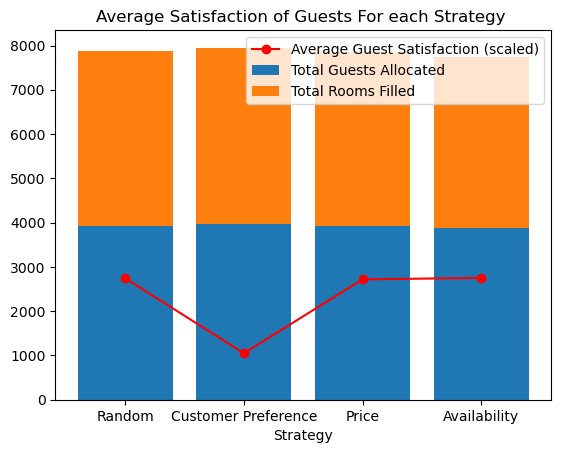

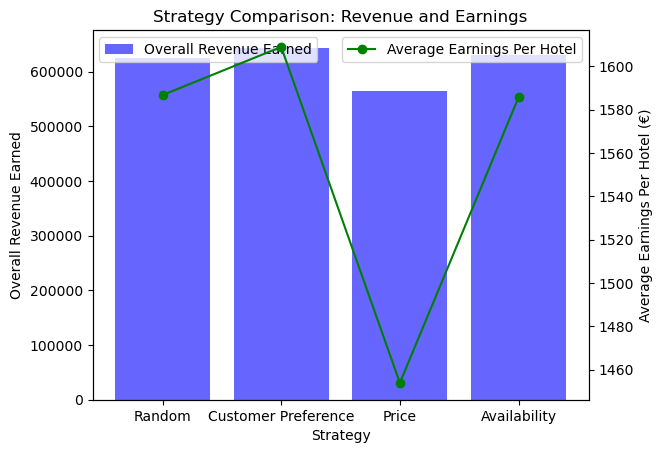

In [1]:
import pandas as pd
import os
from IPython.display import display, HTML, FileLink
import numpy as np
import random
import matplotlib.pyplot as plt


# Function to clean data
def clean_data(df, dataset_type):
    # Remove unnamed columns
    df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col], errors='ignore')

    # Check for missing values
    if df.isnull().sum().any():
        raise ValueError(f"Missing values found in {dataset_type} dataset")

    # Data-specific checks
    if dataset_type == 'hotels':
        if (df['rooms'] < 0).any() or (df['price'] < 0).any():
            raise ValueError("Negative values found in room count or price in hotels dataset")
    elif dataset_type == 'guests':
        if (df['discount'] < 0).any() or (df['discount'] > 1).any():
            raise ValueError("Invalid discount values in guests dataset")
    elif dataset_type == 'preferences':
        if (df['priority'] <= 0).any():
            raise ValueError("Non-positive priority values found in preferences dataset")

    return df

# Function to load datasets
def load_datasets(hotels_path, guests_path, preferences_path):
    hotels_df = pd.read_excel(hotels_path)
    guests_df = pd.read_excel(guests_path)
    preferences_df = pd.read_excel(preferences_path)

    # Clean and validate data
    hotels_df = clean_data(hotels_df, 'hotels')
    guests_df = clean_data(guests_df, 'guests')
    preferences_df = clean_data(preferences_df, 'preferences')

    return hotels_df, guests_df, preferences_df

# Random Allocation function 
def random_allocation(guests_df, hotels_df, preferences_df):
    allocation = {'guest': [], 'hotel': [], 'final_price': [], 'guest_satisfaction': []}
    random_guest = np.random.choice(guests_df['guest'], size=len(guests_df), replace=False).tolist()
    hotel_list = pd.Series(hotels_df['rooms'].values, index=hotels_df['hotel'])
    random_hotel = hotel_list.sample(frac=1).to_dict()
    
    allocated_guests = set()  # Set to keep track of already allocated guests

    for guest in random_guest:
        if guest in allocated_guests:  # Skip if guest is already allocated
            continue

        guest_discount = guests_df[guests_df['guest'] == guest]['discount'].values[0]
        priority_hotels = preferences_df[preferences_df['guest'] == guest].sort_values(by='priority')['hotel'].tolist()
        
        for hotel in random_hotel:
            if hotel in priority_hotels and random_hotel[hotel] > 0:
                random_hotel[hotel] -= 1
                gross_earning = hotels_df[hotels_df['hotel'] == hotel]['price'].values[0]
                net_earning = gross_earning * (1 - guest_discount)
                satisfaction = 1 if priority_hotels.index(hotel) + 1 == 1 else (
                    2 if priority_hotels.index(hotel) + 1 <= (len(priority_hotels) * 0.25) else (
                    3 if priority_hotels.index(hotel) + 1 <= (len(priority_hotels) * 0.5) else (
                    4 if priority_hotels.index(hotel) + 1 < (len(priority_hotels) * 0.75) else 5)))
                allocation['guest'].append(guest)
                allocation['hotel'].append(hotel)
                allocation['final_price'].append(net_earning)
                allocation['guest_satisfaction'].append(satisfaction)
                
                allocated_guests.add(guest)  # Mark the guest as allocated
                break  # Move to the next guest

    return pd.DataFrame(allocation)



# Customer Preference Allocation function
def customer_preference_allocation(hotels_df, guests_df, preferences_df):
    # Data Integrity Checks
    # Check for Null Values
    if guests_df['guest'].isnull().any():
        raise ValueError("Missing guest data in guests_df")
    if hotels_df['hotel'].isnull().any():
        raise ValueError("Missing hotel data in hotels_df")
    if preferences_df.isnull().any().any():  # Checks for any null value in the entire DataFrame
        raise ValueError("Missing data in preferences_df")

    # Ensure all guests have preferences
    guests_with_preferences = preferences_df['guest'].unique()
    if not all(guest in guests_with_preferences for guest in guests_df['guest']):
        raise ValueError("Not all guests have hotel preferences")

    # Ensure all preferred hotels exist in the hotels list
    hotels_in_preferences = set(preferences_df['hotel'])
    if not hotels_in_preferences.issubset(set(hotels_df['hotel'])):
        raise ValueError("Some hotels in preferences are not in the hotels list")

    # Sort guests by the order of reservation (assuming the order in the guests_df is the reservation order)
    guests_list = guests_df['guest'].tolist()

    # Initialize the result dictionary
    allocation_results = {
        'guest': [],
        'hotel': [],
        'final_price': [],
        'guest_satisfaction': []  # How high the allocated hotel was on the guest's preference list
    }

    # Convert room availability to a dictionary for faster updates
    room_availability = hotels_df.set_index('hotel')['rooms'].to_dict()

    # Pre-compute discounts and room prices for efficiency
    guest_discounts = guests_df.set_index('guest')['discount'].to_dict()
    hotel_prices = hotels_df.set_index('hotel')['price'].to_dict()

    # Iterate over the list of guests
    for guest in guests_list:
        # Get the discount for the guest
        discount = guest_discounts[guest]

        # Get the ordered list of preferred hotels for the guest
        preferred_hotels = preferences_df[preferences_df['guest'] == guest] \
            .sort_values(by='priority')['hotel'].tolist()

        # Try to find an available hotel from the guest's preferences
        for hotel in preferred_hotels:
            if room_availability.get(hotel, 0) > 0:
                # Update room availability
                room_availability[hotel] -= 1

                # Calculate price paid with discount
                room_price = hotel_prices[hotel]
                final_price = room_price * (1 - discount)

                # Determine preference score (1 is highest preference) and convert to integer
                guest_satisfaction = int(preferred_hotels.index(hotel) + 1)

                # Add to results
                allocation_results['guest'].append(guest)
                allocation_results['hotel'].append(hotel)
                allocation_results['final_price'].append(final_price)
                allocation_results['guest_satisfaction'].append(guest_satisfaction)
                
                break
        else:
            # Guest could not be allocated to any hotel
            allocation_results['guest'].append(guest)
            allocation_results['hotel'].append(None)
            allocation_results['final_price'].append(0)
            allocation_results['guest_satisfaction'].append(None)
            
    allocation_df = pd.DataFrame(allocation_results)
    

    # Convert the guest_satisfaction column to integer type
    allocation_df['guest_satisfaction'] = allocation_df['guest_satisfaction'].fillna(0).astype(int)
    return allocation_df

# Price Allocation function
def price_allocation(hotels_df, guests_df, preferences_df):
    
    allocation = {'guest': [], 'hotel': [], 'final_price': [], 'guest_satisfaction': []}
    
    guest_list = guests_df['guest'].tolist()

    hotel_ordered = hotels_df.sort_values(by='price') 
    hotel_list = pd.Series(hotel_ordered['rooms'].values, index = hotel_ordered.hotel).to_dict()
        
    for guest in guest_list:
            
        guest_discount = guests_df[guests_df['guest'] == guest]['discount'].values[0]

        priority_hotels = preferences_df[preferences_df['guest'] == guest].sort_values(by='priority')['hotel'].tolist()
        
        for hotel in hotel_list:
            if hotel in priority_hotels and hotel_list[hotel]>0:
                hotel_list[hotel] -=1
    
                gross_earning = hotels_df[hotels_df['hotel'] == hotel]['price'].values[0]
                net_earning = gross_earning*(1-guest_discount)
        
                satisfaction = 1 if priority_hotels.index(hotel)+1 == 1 else(
                    2 if priority_hotels.index(hotel)+1 <= (len(priority_hotels) * 0.25) else(
                    3 if priority_hotels.index(hotel)+1 <= (len(priority_hotels) * 0.5) else(
                    4 if priority_hotels.index(hotel)+1 < (len(priority_hotels) * 0.75) else 5)))
        
                allocation['guest'].append(guest)
                allocation['hotel'].append(hotel)
                allocation['final_price'].append(net_earning)
                allocation['guest_satisfaction'].append(satisfaction)
                break

    price_allocation = pd.DataFrame(allocation)
    return price_allocation

def availability_allocation(hotels_df, guests_df, preferences_df):
    
    allocation = {'guest': [], 'hotel': [], 'final_price': [], 'guest_satisfaction': []}
    
    guest_list = guests_df['guest'].tolist()

    hotel_ordered = hotels_df.sort_values(by='rooms') 
    hotel_list = pd.Series(hotel_ordered['rooms'].values, index = hotel_ordered.hotel).to_dict()
        
    for guest in guest_list:
            
        guest_discount = guests_df[guests_df['guest'] == guest]['discount'].values[0]

        priority_hotels = preferences_df[preferences_df['guest'] == guest].sort_values(by='priority')['hotel'].tolist()
        
        for hotel in hotel_list:
            if hotel in priority_hotels and hotel_list[hotel]>0:
                hotel_list[hotel] -=1
    
                gross_earning = hotels_df[hotels_df['hotel'] == hotel]['price'].values[0]
                net_earning = gross_earning*(1-guest_discount)
        
                satisfaction = 1 if priority_hotels.index(hotel)+1 == 1 else(
                    2 if priority_hotels.index(hotel)+1 <= (len(priority_hotels) * 0.25) else(
                    3 if priority_hotels.index(hotel)+1 <= (len(priority_hotels) * 0.5) else(
                    4 if priority_hotels.index(hotel)+1 < (len(priority_hotels) * 0.75) else 5)))
        
                allocation['guest'].append(guest)
                allocation['hotel'].append(hotel)
                allocation['final_price'].append(net_earning)
                allocation['guest_satisfaction'].append(satisfaction)
                break

    allocation_df = pd.DataFrame(allocation)
    return allocation_df


# Function to calculate metrics
def calculate_metrics(allocation_df, hotels_df):
    # Ensure 'guest_satisfaction' column exists and handle if not
    if 'guest_satisfaction' not in allocation_df.columns:
        allocation_df['guest_satisfaction'] = np.nan  # Fill with NaN if column doesn't exist

    allocated_room_counts = allocation_df['hotel'].value_counts()
    hotels_fully_occupied = sum(
        allocated_room_counts.get(hotel, 0) == room_count
        for hotel, room_count in hotels_df.set_index('hotel')['rooms'].items()
    )

    # For 'Total Guests Allocated', count only non-null allocations if 'hotel' column can be null
    total_guests_allocated = allocation_df[allocation_df['hotel'].notnull()].shape[0]

    # For 'Total Rooms Filled', sum the filled rooms, considering only non-null hotel allocations
    total_rooms_filled = allocated_room_counts.sum()

    # Calculating metrics with rounding applied uniformly for consistency
    results = {
        "Total Guests Allocated": total_guests_allocated,
        "Total Rooms Filled": total_rooms_filled,
        "Number of Hotels Utilized": allocation_df['hotel'].nunique(),
        "Full Capacity Hotels Count": hotels_fully_occupied,
        "Overall Revenue Earned": round(allocation_df['final_price'].sum(), 2),
        "Average Earnings Per Hotel": round(allocation_df.groupby('hotel')['final_price'].sum().mean(), 2),
        "Average Guest Satisfaction": round(allocation_df['guest_satisfaction'].mean(), 2) if not allocation_df['guest_satisfaction'].isna().all() else np.nan
    }

    return pd.DataFrame(list(results.items()), columns=['Metric', 'Value'])


def extract_metrics(df):
    return {
        'Total Guests Allocated': df.loc[df['Metric'] == 'Total Guests Allocated', 'Value'].values[0],
        'Total Rooms Filled': df.loc[df['Metric'] == 'Total Rooms Filled', 'Value'].values[0],
        'Number of Hotels Utilized': df.loc[df['Metric'] == 'Number of Hotels Utilized', 'Value'].values[0],
        'Full Capacity Hotels Count': df.loc[df['Metric'] == 'Full Capacity Hotels Count', 'Value'].values[0],
        'Overall Revenue Earned': df.loc[df['Metric'] == 'Overall Revenue Earned', 'Value'].values[0],
        'Average Earnings Per Hotel': df.loc[df['Metric'] == 'Average Earnings Per Hotel', 'Value'].values[0],
        'Average Guest Satisfaction': df.loc[df['Metric'] == 'Average Guest Satisfaction', 'Value'].values[0]
    }



def style_dataframe(df):
    if 'final_price' in df.columns:  # Check if final_price column is present
        return df.style \
            .background_gradient(cmap='Blues') \
            .set_properties(**{'text-align': 'left', 'font-size': '12pt'}) \
            .format({'final_price': "€{:,.2f}"}) \
            .set_table_styles([{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]}])
    else:  # For the metrics table
        # Custom formatter for different metrics
        def custom_format(x, metric):
            if metric in ["Overall Revenue Earned", "Average Earnings Per Hotel"]:
                return f"€{x:,.4f}"
            elif metric == "Average Guest Satisfaction":
                return f"{x:.2f}"
            return f"{x:,.0f}"

        return df.style \
            .background_gradient(cmap='Blues') \
            .set_properties(**{'text-align': 'left', 'font-size': '12pt'}) \
            .format({'Value': lambda x: custom_format(x, df[df['Value'] == x]['Metric'].iloc[0])}) \
            .set_table_styles([{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]}])



# Function to save results and show sub of the tables 
def save_files(allocation_df, results_df, directory, strategy_name):
    if not os.path.exists(directory):
        os.makedirs(directory)

    try:
        csv_path = os.path.join(directory, f'{strategy_name}_results.csv')
        txt_path = os.path.join(directory, f'summary_report_{strategy_name}.txt')

        allocation_df.to_csv(csv_path, index=False)
        with open(txt_path, 'w') as file:
            file.write(f"Summary Report of {strategy_name} Strategy\n")
            file.write("-------------------------------------------------\n")
            file.writelines([f"{row['Metric']}: {row['Value']}\n" for _, row in results_df.iterrows()])

        return csv_path, txt_path
    except Exception as e:
        print(f"Error saving files: {e}")
        return None, None


# Function to display with description
def display_with_description(description, dataframe, post_description=None):
    display(HTML(description))
    display(style_dataframe(dataframe))
    if post_description:
        display(HTML(post_description))
        
        
def display_download_links(csv_path, txt_path):
    if csv_path:
        display(FileLink(csv_path, result_html_prefix="Download CSV: "))
    if txt_path:
        display(FileLink(txt_path, result_html_prefix="Download Summary Report: "))




def plot_Satisfaction(comparison_df):
    strategies = comparison_df['Strategy']
    total_guests = comparison_df['Total Guests Allocated']
    total_rooms = comparison_df['Total Rooms Filled']
    avg_satisfaction = comparison_df['Average Guest Satisfaction']

    x = np.arange(len(strategies))  # Label locations

    fig, ax = plt.subplots()
    ax.bar(strategies, total_guests, label='Total Guests Allocated')
    ax.bar(strategies, total_rooms, bottom=total_guests, label='Total Rooms Filled')
    ax.plot(strategies, avg_satisfaction * max(total_guests) / 5, color='red', marker='o', label='Average Guest Satisfaction (scaled)')

    ax.set_xlabel('Strategy')
    ax.set_title('Average Satisfaction of Guests For each Strategy ')
    ax.legend()

    plt.show()



def plot_revenue_chart(comparison_df):
    strategies = comparison_df['Strategy']
    overall_revenue = comparison_df['Overall Revenue Earned']
    avg_earnings = comparison_df['Average Earnings Per Hotel']

    fig, ax1 = plt.subplots()

    # Plotting the bar chart for overall revenue
    ax1.bar(strategies, overall_revenue, color='blue', alpha=0.6, label='Overall Revenue Earned')

    # Adding labels and title
    ax1.set_xlabel('Strategy')
    ax1.set_ylabel('Overall Revenue Earned')
    ax1.set_title('Strategy Comparison: Revenue and Earnings')
    ax1.legend(loc='upper left')

    # Plotting the line chart for average earnings
    ax2 = ax1.twinx()
    ax2.plot(strategies, avg_earnings, color='green', marker='o', label='Average Earnings Per Hotel')
    ax2.set_ylabel('Average Earnings Per Hotel (€)')
    ax2.legend(loc='upper right')
    
    plt.show()

def shorten_strategy_names(comparison_df):
    # Shorten or modify strategy names as desired
    comparison_df['Strategy'] = comparison_df['Strategy'].replace({
        'Random Allocation': 'Random',
        'Customer Preference Allocation': 'Customer Preference',
        'Price Allocation': 'Price',
        'Availability Allocation': 'Availability'
    })
    return comparison_df


# Main execution block
def main():
    # Paths to the data files
    hotels_path = 'C:/Users/irpay/OneDrive/Documents/GitHub/payam/hotels.xlsx'
    guests_path = 'C:/Users/irpay/OneDrive/Documents/GitHub/payam/guests.xlsx'
    preferences_path = 'C:/Users/irpay/OneDrive/Documents/GitHub/payam/preferences.xlsx'

    # Load and clean datasets
    hotels_df, guests_df, preferences_df = load_datasets(hotels_path, guests_path, preferences_path)

    # Execute Random Allocation Strategy
    random_allocation_df = random_allocation(guests_df, hotels_df, preferences_df)
    random_results_df = calculate_metrics(random_allocation_df, hotels_df)


    # Execute Customer Preference Allocation Strategy
    customer_preference_allocation_df = customer_preference_allocation(hotels_df, guests_df, preferences_df)
    customer_preference_results_df = calculate_metrics(customer_preference_allocation_df, hotels_df)
    
    # Execute Price Allocation Strategy
    price_allocation_df = price_allocation(hotels_df, guests_df, preferences_df)
    price_allocation_results_df = calculate_metrics(price_allocation_df, hotels_df)
    
    # Execute Availability  Allocation Strategy
    availability_allocation_df = availability_allocation(hotels_df, guests_df, preferences_df)
    availability_allocation_results_df = calculate_metrics(availability_allocation_df, hotels_df)
        

    # Descriptions and post-descriptions for Allocation and Metrics tables
    allocation_description = "<b>Table {table_number}: {strategy_name} Allocation Results Summary</b><br>This table shows the distribution of guests across various hotels, the price paid, and their satisfaction scores."
    allocation_post_description = "*Note: Only the first 5 rows are displayed for brevity. For the complete data, please use the download link below.*"
    metrics_description = "<b>Table {table_number}: {strategy_name} Allocation Performance Metrics</b><br>This table provides key metrics summarizing the allocation's effectiveness, including total guests allocated, revenue earned, and average guest satisfaction."
    metrics_post_description = "*Note: Guest satisfaction scores range from 1 to 5, with 1 being the guest's top choice and 5 being around their last preference.*"

    # Display and save results for Random Allocation Strategy
    display(HTML("<h2>Random Allocation Strategy Results</h2>"))
    display_with_description(allocation_description.format(table_number="1", strategy_name="Random"), random_allocation_df.head(), allocation_post_description)
    display_with_description(metrics_description.format(table_number="2", strategy_name="Random"), random_results_df, metrics_post_description)
    csv_path, txt_path = save_files(random_allocation_df, random_results_df, 'results', 'random_allocation')
    display_download_links(csv_path, txt_path)

    # Display and save results for Customer Preference Allocation Strategy
    display(HTML("<h2>Customer Preference Allocation Strategy Results</h2>"))
    display_with_description(allocation_description.format(table_number="3", strategy_name="Customer Preference"), customer_preference_allocation_df.head(), allocation_post_description)
    display_with_description(metrics_description.format(table_number="4", strategy_name="Customer Preference"), customer_preference_results_df, metrics_post_description)
    csv_path, txt_path = save_files(customer_preference_allocation_df, customer_preference_results_df, 'results', 'customer_preference')
    display_download_links(csv_path, txt_path)
    
    # Display and save results for Price  Allocation Strategy
    display(HTML("<h2>Price Allocation Strategy Results</h2>"))
    display_with_description(allocation_description.format(table_number="5", strategy_name="Price Allocation"), price_allocation_df.head(), allocation_post_description)
    display_with_description(metrics_description.format(table_number="6", strategy_name="Price Allocation"), price_allocation_results_df, metrics_post_description)
    csv_path, txt_path = save_files(price_allocation_df, price_allocation_results_df, 'results', 'Price Allocation')
    display_download_links(csv_path, txt_path)

    # Display and save results for availability Allocation Strategy
    display(HTML("<h2>Availability Allocation Strategy Results</h2>"))
    display_with_description(allocation_description.format(table_number="7", strategy_name="Availability Allocation"), availability_allocation_df.head(), allocation_post_description)
    display_with_description(metrics_description.format(table_number="8", strategy_name="Availability Allocation"), availability_allocation_results_df, metrics_post_description)
    csv_path, txt_path = save_files(availability_allocation_df, availability_allocation_results_df, 'results', 'availability_allocation')

    display_download_links(csv_path, txt_path)
    
    # Extract metrics for each strategy- TABLE 
    random_metrics = extract_metrics(random_results_df)
    customer_preference_metrics = extract_metrics(customer_preference_results_df)
    price_allocation_metrics = extract_metrics(price_allocation_results_df)
    availability_allocation_metrics = extract_metrics(availability_allocation_results_df)
   

    # Create the comparison dataframe- TABLE 
    #  the comparison dataframe
    comparison_df = pd.DataFrame(columns=[
        'Strategy', 
        'Total Guests Allocated', 
        'Total Rooms Filled', 
        'Number of Hotels Utilized', 
        'Full Capacity Hotels Count', 
        'Overall Revenue Earned', 
        'Average Earnings Per Hotel', 
        'Average Guest Satisfaction'
    ])

    # Create dataframes for each strategy and concatenate them- TABLE 
    df_random = pd.DataFrame([{**{'Strategy': 'Random Allocation'}, **random_metrics}])
    df_customer_preference = pd.DataFrame([{**{'Strategy': 'Customer Preference Allocation'}, **customer_preference_metrics}])
    df_price_allocation = pd.DataFrame([{**{'Strategy': 'Price Allocation'}, **price_allocation_metrics}])
    df_availability_allocation = pd.DataFrame([{**{'Strategy': 'Availability Allocation'}, **availability_allocation_metrics}])

    comparison_df = pd.concat([comparison_df, df_random, df_customer_preference, df_price_allocation, df_availability_allocation], ignore_index=True)



    # Display the comparison table
    display(comparison_df)
    
    comparison_df = shorten_strategy_names(comparison_df)
    plot_Satisfaction(comparison_df)
    plot_revenue_chart(comparison_df)


if __name__ == "__main__":
    main()
